In [1]:
# Run this cell for autoreload of modules
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import glob
from astropy.io import fits
from tqdm import tqdm
from PIL import Image

In [2]:
import sys
import os

# Construct the absolute path to the 'mae' repository
mae_repo_path = os.path.abspath("mae")

# Check if the path exists and, if not already added, insert it into sys.path
if os.path.isdir(mae_repo_path) and mae_repo_path not in sys.path:
    sys.path.insert(0, mae_repo_path)

print("Added MAE repository to sys.path:", mae_repo_path)

Added MAE repository to sys.path: /home/guillermo/ssd/Github/gsoc25-exxa/mae


### PyTorch Dataset 

In [24]:
class ALMADataset:
    def __init__(self, fits_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(fits_dir, '*.fits')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        with fits.open(file) as hdul:
            image = hdul[0].data[0, 0, 0, ...]
        image = np.array(image, dtype=np.float32).copy()
        label = -1  # dummy label
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [26]:
class LogTransform(object):
    def __init__(self, scale_factor=1e21, eps=1e-10):
        self.scale_factor = scale_factor
        self.eps = eps

    def __call__(self, image):
        # image is a numpy array
        arr = np.array(image, dtype=np.float32)
        arr = np.log1p(arr * self.scale_factor + self.eps)
        return Image.fromarray(arr)

dataset = ALMADataset(fits_dir='continuum_data_subset', transform=LogTransform(scale_factor=1e21))
dataset[0][0].size

(600, 600)

Compute statistics

In [27]:
sum_pixels = 0.0
sum_sq_pixels = 0.0
num_pixels = 0

# Iterate over the dataset
for i in tqdm(range(len(dataset)), desc="Computing stats"):
    img, _ = dataset[i]
    # Ensure the image is a numpy array
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    pixels = img.flatten()  # Flatten the image to a 1D array
    sum_pixels += np.sum(pixels)
    sum_sq_pixels += np.sum(pixels**2)
    num_pixels += pixels.size

# Compute global mean and standard deviation
global_mean = sum_pixels / num_pixels
global_std = np.sqrt((sum_sq_pixels / num_pixels) - global_mean**2)

print("Global Mean:", global_mean)
print("Global Std:", global_std)

Computing stats: 100%|██████████| 150/150 [00:01<00:00, 148.32it/s]

Global Mean: 0.10948892767107929
Global Std: 0.23363521474947446


In [28]:
from torchvision import transforms
    
alma_transform = transforms.Compose([
    LogTransform(scale_factor=1e21),
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.10948892767107929], std=[0.23363521474947446])
    ])

In [29]:
dataset = ALMADataset(fits_dir='continuum_data_subset', transform=alma_transform)
dataset[0][0].shape

torch.Size([1, 224, 224])

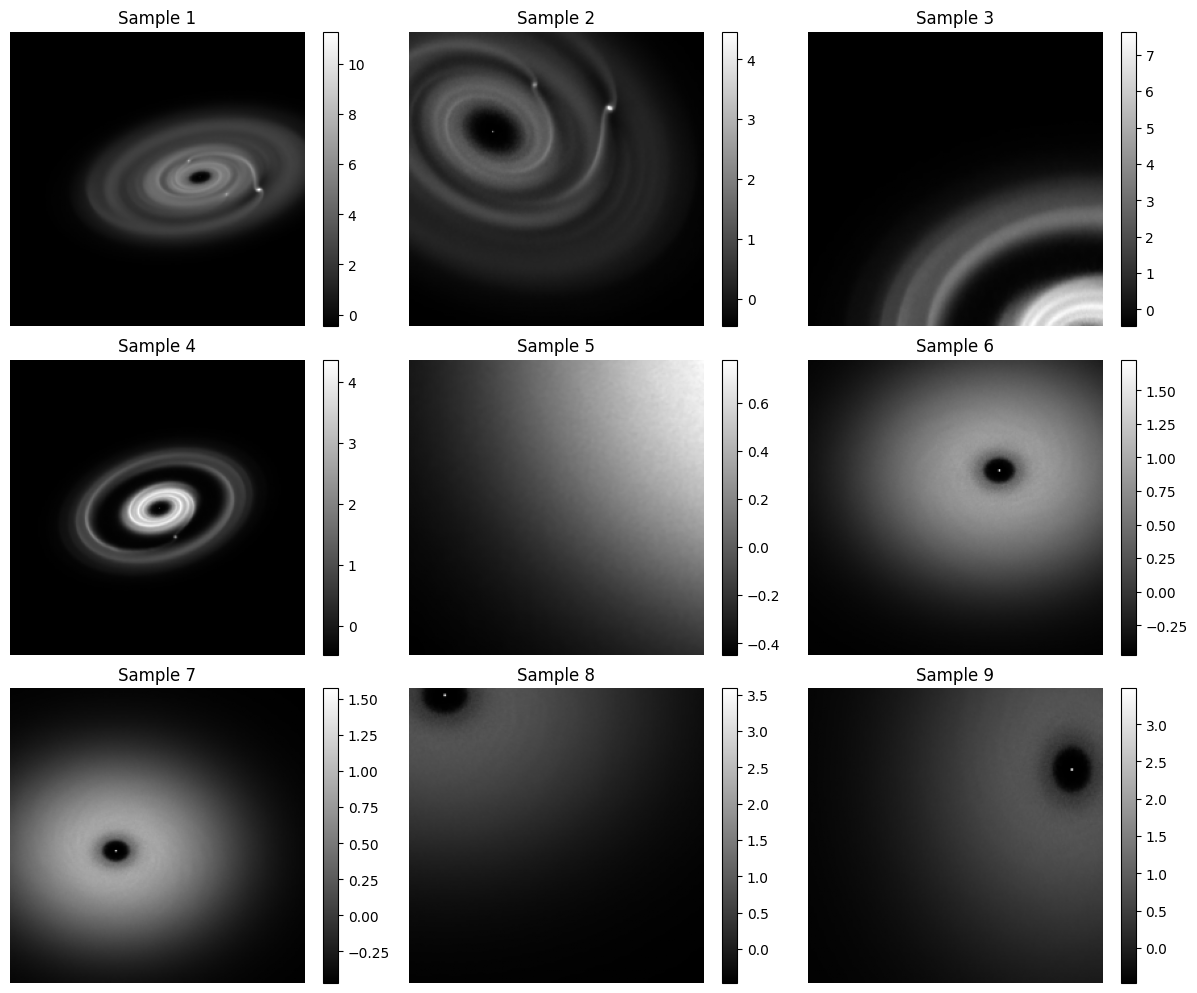

In [30]:
import matplotlib.pyplot as plt

# Collect 9 sample images from the dataset (ignoring labels)
samples = [dataset[i][0] for i in range(9)]

plt.figure(figsize=(12, 10))
for i, img in enumerate(samples):
    # If the image is a torch tensor, convert to numpy
    if hasattr(img, "cpu"):
        img = img.cpu().numpy()
    # Assume image shape is (C, H, W). If single channel, remove channel dimension.
    if img.shape[0] == 1:
        img = img.squeeze(0)
    elif img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.colorbar()
    plt.title(f"Sample {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Pre-training

In [ ]:
def pretrain_model(model, dataloader, optimizer, num_epochs=10, mask_ratio=0.75, device="cuda"):
    """
    Minimal training loop with MS-SSIM loss and progress bar.
    The PyTorch differentiable Multi-Scale Structural Similarity (MS-SSIM) loss is calculated 
    alongside the MSE loss and both are used in the backward pass.
    Parameters:
      model: Model to be trained.
      dataloader: DataLoader providing images.
      optimizer: Optimizer used to update model parameters.
      num_epochs: Number of training epochs.
      mask_ratio: Ratio of patches to mask.
      device: Device to use.
    """
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        total_mse = 0.0
        total_ms_ssim = 0.0
        total_loss = 0.0
        
        # Wrap the dataloader with tqdm for a progress bar.
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for imgs, _ in pbar:  # each item is expected to be (image, dummy_label)
            imgs = imgs.to(device)
            optimizer.zero_grad()
            # Forward pass with MS-SSIM loss calculation; both losses are returned
            mse_loss, ms_ssim_loss, _, _ = model(imgs, mask_ratio=mask_ratio, compute_ms_ssim=True)
            loss = mse_loss + ms_ssim_loss
            loss.backward()
            optimizer.step()
            
            total_mse += mse_loss.item()
            total_ms_ssim += ms_ssim_loss.item()
            total_loss += loss.item()
            
            # Update the progress bar description with current loss values.
            pbar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "MSE": f"{mse_loss.item():.4f}",
                "MS-SSIM": f"{ms_ssim_loss.item():.4f}"
            })
        avg_mse = total_mse / len(dataloader)
        avg_ms_ssim = total_ms_ssim / len(dataloader)
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}: Total Loss = {avg_loss:.4f}, MSE = {avg_mse:.4f}, MS-SSIM Loss = {avg_ms_ssim:.4f}")
    return model

In [ ]:
import torch
from torch.utils.data import DataLoader
from models_mae import mae_vit_base_patch16

# Using the previously defined ALMADataset
# Adjust parameters as needed, e.g., use a small batch_size for testing
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Instantiate the model with minimal parameters (modify in_channels as required)
model = mae_vit_base_patch16(img_size=224, in_chans=1, norm_pix_loss=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Run a simple pre-training for 2 epochs (adjust num_epochs as preferred)
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrain_model(model, dataloader, optimizer, num_epochs=100, mask_ratio=0.75, device=device)

/home/guillermo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/2: Total Loss = 1.2640, MSE = 0.8427, MS-SSIM Loss = 0.4213


Epoch 2/2: Total Loss = 0.9294, MSE = 0.6531, MS-SSIM Loss = 0.2763


## Latent space

Latent Representation Shape: torch.Size([1, 197, 768])
First 5 latent vector values: [[-1.1020025  -0.43877557  1.5161839  ... -0.04203388 -0.34512755
  -1.1182371 ]
 [-1.1561329   0.03524321  0.52093655 ...  0.48705858 -0.308008
  -0.49534634]
 [-0.6285579  -0.89228344  1.6484146  ...  0.48041502 -0.71878815
  -0.9702076 ]
 [-0.93285644 -0.9441904   1.5286139  ...  0.49395996 -0.6643155
  -1.0049186 ]
 [-0.64317477 -1.0687      1.557664   ...  0.59178215 -0.712294
  -1.0041813 ]]


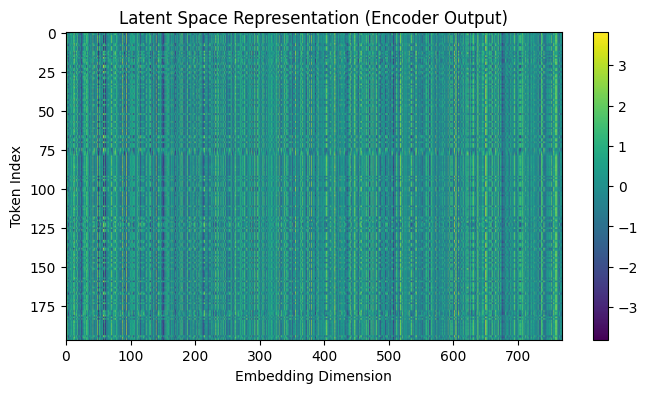

In [ ]:
model.eval()  # Set the model in evaluation mode

# Prepare an example: load the first image from the dataset
example_img, _ = dataset[0]

# Convert the image to a tensor if needed (assuming your transforms did not already do so)
if not isinstance(example_img, torch.Tensor):
    example_img = transforms.ToTensor()(example_img)

# Add a batch dimension and move the image to the device (e.g., "cuda")
example_img = example_img.unsqueeze(0).to("cuda")

# Perform a forward pass through the encoder with no masking (mask_ratio=0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(example_img, mask_ratio=0)

# Print the shape of the latent representation and show some values
print("Latent Representation Shape:", latent.shape)
latent_np = latent.cpu().numpy()
print("First 5 latent vector values:", latent_np[0, :5])

plt.figure(figsize=(8, 4))
plt.imshow(latent_np[0], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Latent Space Representation (Encoder Output)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Index")
plt.show()

The 197 rows correspond to 196 patch tokens (from a 14×14 patch division) plus one extra token. In many transformer-based vision models, an additional token (often interpreted as a classification token) is appended to the patch tokens. Even though this extra token may not be used directly for classification in MAE pretraining, it is still included in the output, resulting in 197 rows. To analyze only the patch embeddings, we can use latent_np[0, :-1].

## MAE reconstruction

In [ ]:
import torch
from torch.utils.data import DataLoader
from models_mae import mae_vit_base_patch16

# Using the previously defined ALMADataset
# Adjust parameters as needed, e.g., use a small batch_size for testing
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Instantiate the model with minimal parameters
model = mae_vit_base_patch16(img_size=224, in_chans=1, norm_pix_loss=False) # trained with pixels as targets for visualization
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Run a simple pre-training for 2 epochs (adjust num_epochs as preferred)
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrain_model(model, dataloader, optimizer, num_epochs=100, mask_ratio=0.75, device=device)

In [83]:
def show_image(image, title=''):
    # image_norm = torch.clip((image * global_std + global_mean) * 255, 0, 255).int()
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_one_image(img, model):
    """
    Process a single image through the MAE model to obtain the reconstruction.
    Adapted for single-channel input images.
    """
    # Ensure image has shape [H, W, 1]
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    
    x = torch.tensor(img)  # shape: H x W x 1
    x = x.unsqueeze(0)     # add batch dimension: 1 x H x W x 1
    x = torch.einsum('nhwc->nchw', x)  # convert to [B, C, H, W]
    
    # Run the MAE forward pass with mask_ratio=0.75 (as used during training)
    with torch.no_grad():
        _, _, y, mask = model(x.float(), mask_ratio=0.75)
    
    # Reconstruct image from patches
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # Process the mask:
    # Since the data is single-channel, repeat once to match the number of pixels in a patch.
    mask = mask.detach().unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 1)
    mask = model.unpatchify(mask)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    
    # Create masked image and pasted reconstruction image
    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + y * mask
    
    plt.rcParams['figure.figsize'] = [30, 5]
    plt.subplot(1, 4, 1)
    show_image(x[0].cpu().numpy(), "Original")
    
    plt.subplot(1, 4, 2)
    show_image(im_masked[0].cpu().numpy(), "Masked")
    
    plt.subplot(1, 4, 3)
    show_image(y[0].cpu().numpy(), "Reconstruction")
    
    plt.subplot(1, 4, 4)
    show_image(im_paste[0].cpu().numpy(), "Reconstruction + Visible")
    
    plt.show()

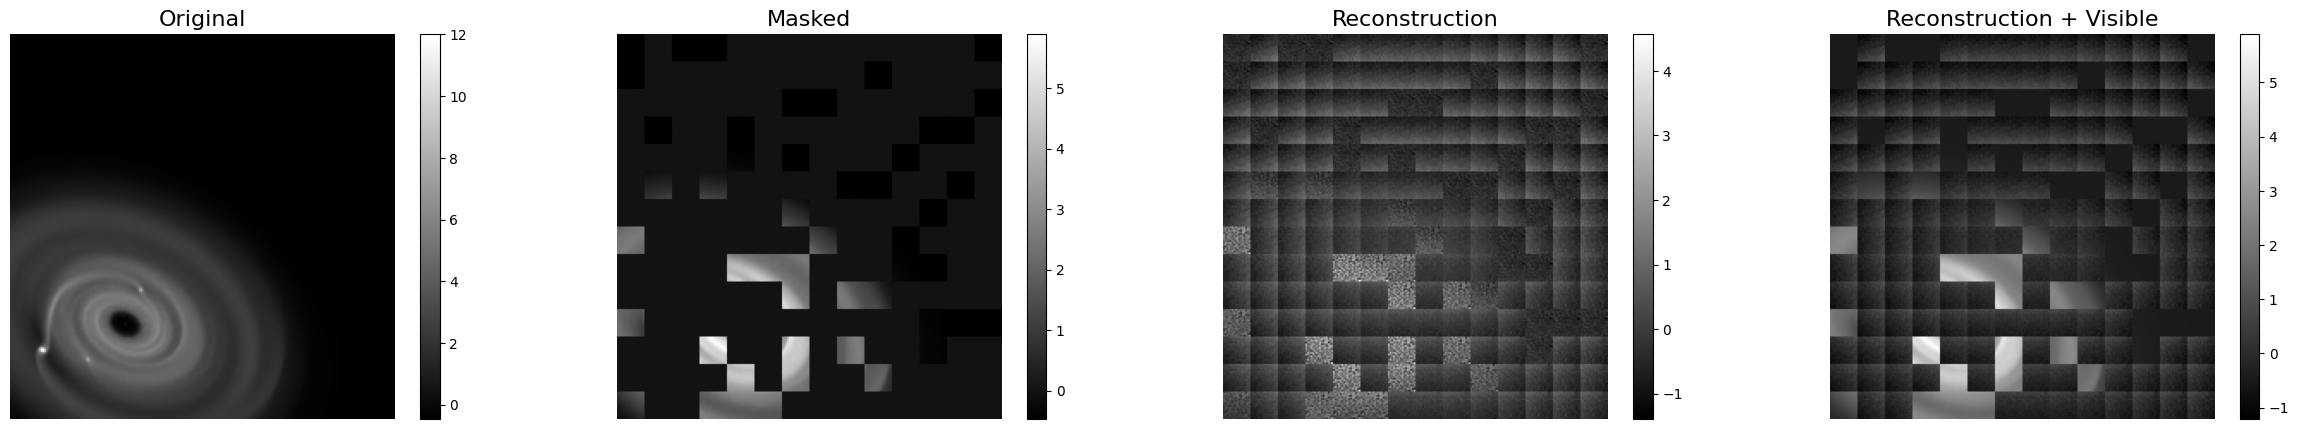

: 

In [ ]:
# Example:
model = model.to('cpu')
example_img = dataset[0][0][0]  # your dataset returns a single-channel image
run_one_image(example_img, model)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

212

: 